# Particle Filter with Julia

## Introduction

In time series models that have latent variables (i.e. have unobservable variables), particle filters (PF) are used to estimate the path of the latent variables up to time $t$ using only information available at time $t$. This operation is called filtering, and it is what gives the PF its name (or at least, part of it). But PF can also be used to estimate the path of the latent variables using all the data, an operation that is called smoothing. Last, but not least, PF are useful to integrate the unobservable variables out of the joint density of observable and unobservable variables to get the marginal density of the observable variables---the likelihood, which can be used to estimate the unknown parameter of the model by using standard Bayesian computational tools.

This Julia notebook describes the PF algorithms and its implementation in Julia. The objective is not to write efficient code, but to provide a pedagogical overview of the PF based on actual code. 

## Requirement

In these notes I am assuming the use of julia-0.4.5. With earlier (or later version) the code below is not guaranteed to excecute without wome twicking. 

The timings presented are relative to this machine.

In [212]:
versioninfo()

Julia Version 0.4.5
Commit 2ac304d (2016-03-18 00:58 UTC)
Platform Info:
  System: Darwin (x86_64-apple-darwin15.4.0)
  CPU: Intel(R) Core(TM) i7-3540M CPU @ 3.00GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Sandybridge)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


This notebook requires the following packages to be installed and loadable on your installation of Julia. 

In [213]:
pkgs = ["Distributions", "Mamba", "StatsBase", "StatsFuns", "Plots"]
ver = [Pkg.installed(u) for u in pkgs];
[pkgs ver]

5x2 Array{Any,2}:
 "Distributions"  v"0.8.10"
 "Mamba"          v"0.9.0" 
 "StatsBase"      v"0.8.1" 
 "StatsFuns"      v"0.2.1" 
 "Plots"          v"0.5.4+"

In [ ]:
using Distributions
using Mamba
using StatsBase
using StatsFuns
using Plots
gadfly()


## Particle filter typical model


Particle methods assume $\{X_{t}\}_{t\geq1}$ and the observations $\{Y_{t}\}_{t\geq1}$ satisfy the following setup:


1. $X_{1},X_{2},\ldots$ is a first order Markov process such that 
$$
X_{t}|\left(X_{t-1}=x_{t-1}\right)\sim f_{\theta}(\cdot|x_{t-1})
$$
with an initial distribution
$$
X_{1}\sim\mu_{\theta}(x_{1}).
$$
 
2. Given $\{X_{t}\}_{t\geq1}$, the observations $\{Y_{t}\}_{t\geq1}$
are statistically independent, and their marginal conditional densities are given
$$
Y_{t}|\left(X_{t}=x_{t}\right)\sim g_{\theta}(y_{t}|x_{t}),
$$

A model with these characteristics is the Stochastic Volatility model. 

## Stochastic Volatility

The stochastic volatility model:

\begin{align*}
X_{t} & =\alpha X_{t-1}+\sigma V_{t}\\
Y_{t} & =\beta\exp\left(X_{t}/2\right)W_{t}
\end{align*}
where
$$
V_{n}\sim N(0,1),\quad W_{n}\sim N(0,1).
$$

In the notation of the generic model, we have:

$$
\theta=(\alpha,\sigma,\beta),\,\,\mu_{\theta}(x)=N\left(x;0,\frac{\sigma^{2}}{1-\alpha^{2}}\right),
$$

$$
f_{\theta}(x_{t}|x_{t-1})=N(x_{t};\alpha x_{t-1},\sigma^{2})
$$
and
$$
g_{\theta}(y_{t}|x_{t})=N\left(y;0,\beta^{2}\exp(x)\right).
$$

## Simulating the SV model

We start by simulating a series $Y$ from the SV model using as parameters 
$$
\alpha_0 = 0.91,\,\ \sigma_0 = 1\,\, \beta_0 = 0.5.
$$

We let $\theta = [\alpha, \sigma, \beta]$, and $\theta_0 = [0.91, 1.0, 0.5]$.



In [159]:

function simSV(θ, T=100)
    α, σ, β = θ
    println("Simulating SVM")
    println("α = ", α, ", σ = ", σ, ", β = ", β)    
    X = Array(Float64, T + 1)
    Y = Array(Float64, T)
    X[1] = 0.0
    for t = 1:T
        X[t+1] = α*X[t] + σ*randn()
        Y[t]   = β*exp(X[t]/2)*randn()
        
    end
    return Y, X
end
    
θ = [.91, 1.0, 0.5];
srand(1)
Y, X_true = simSV(θ, 500);

Simulating SVM
α = 0.91 σ = 1.0 β = 0.5


In [ ]:
We plot the observations (Y) and the volatility (X). 

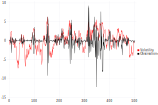

In [160]:
plot(y = X_true[2:end], color = :red, lab = "Volatility")
plot!(y=Y, color = :black, lab = "Observations")

## Particle filter algorithm
The generic algorithm can be described as follows.

At time $t=1$

- Sample $X_{1}^{i}\sim q_{1}(x_{1})$
- Compute the weights $w_{1}(X_{1}^{i})=\frac{\mu(X_{1}^{i})g(y_{1}|X_{1}^{i})}{q(X_{1}^{i}|y_{1})}$
and $W_{1}^{i}\propto w_{1}(X_{1}^{i})$

At time $t\geq2$


- Sample $X_{t}^{i}\sim q_{t}(x_{t}|y_{t},X_{1:t-1}^{i})$ 
- Compute the weights
$$
\alpha_{t}(X_{1:t}^{i})=\frac{g_{\theta}(y_{t}|X_{t}^{i})f_{\theta}(X_{t}^{i}|X_{t-1}^{i})}{q_{t}(X_{t}^{i}|X_{1:t-1}^{i},y_{1:t})}
$$
\begin{align*}
w_{t}(X_{1:t}^{i}) & ={w_{t-1}(X_{1:t-1}^{i})}{\alpha_{t}(X_{1:t})}\\
W_{t}^{i} & \propto w_{t}(X_{1:t}^{i})
\end{align*}

The proposal distribution, generically denoted $q_{t}(X_{t}^{i}|X_{1:t-1}^{i},y_{1:t})$ in the algorithm above, needs to be choosen to make the algorithm feasible. A common choice is to set
$$
q_{t}(X_{t}^{i}|X_{1:t-1}^{i},y_{1:t}) = f_{\theta}(X_{t}|x_{t-1}).
$$
With choice
$$
\alpha_{t}(X_{1:t})} = g_{\theta}(y_t|x_t).
$$

The function `SIS` below implement the PF just described.

In [8]:
function SIS(θ, Y, N=1000)
    T = size(Ya,1)
    X = Array(Float64, N, T) ## This will store the particles
    W = Array(Float64, N, T) ## This will store the weights
    llik = 0.0
    α, σ, β = θ
    ## Initialize -- Draws particles
    rand!(Normal(0, sqrt(σ^2/(1-α^2))), sub(X, :, 1)) ## X_1 ~ μ
    @inbounds for i = 1:N
        W[i, 1] = pdf(Normal(0, β*exp(X[i]/2)), Y[1]) ## W_1 = g(y|X_i)
    end
    for j = 2:T
        sw = 0.0        
        @inbounds for i = 1:N
            ## Generate particles
            X[i,j] = rand(Normal(α*X[i, j-1], σ))
            ## Update weights
            W[i,j] = W[i,j-1]*pdf(Normal(0, β*exp(X[i,j]/2)), Y[j])
            ## sw will contain sum of the weights
            sw += W[i,j] 
        end
        llik += log(sw)-log(N)
    end    
    (scale!(W, vec(1./sum(W, 1))), X, llik)
end
        
    
    

SIS (generic function with 2 methods)

The function takes three arguments: $\theta$, $Y$, and $N$. The first argument is the parameter vector. The second is the vector of data. The last is the number of particles to be used.

The algorithm is relatively fast---even if it is written with readibility rather than efficiency in mind. With $N=1000$, `SIS` takes less than 0.1 second to finish.

In [219]:
W, X, llik = SIS([0.9, 1., .5], Y, 1000);
@time W, X, llik = SIS([0.9, 1., .5], Y, 1000);

  0.049340 seconds (31 allocations: 7.638 MB, 11.47% gc time)


To verify the quality of the estimate of the volatility, we plot the "true" value of the volatility (that we have here because we are generating the data) and the estimates produced by the PF. As estimates, we use the weighted mean of the particles at each time $t$. 

In [220]:
X_est = Array(Float64, size(X,2))
V_est = Array(Float64, size(X,2))
for t = 1:size(X,2)
    X_est[t] = mean(X[:,t], weights(W[:,t]))
    V_est[t] = var(X[:,t], weights(W[:,t]))
end



Notice that both  `X_est` and `W_est` are $T\times N$ matrices. The column $t$ of $W_est$ contains the particles at time $t$ while `W_est` contains the time $t$ weights. This means that `X_est[t] = mean(X[:,t], weights(W[:,t]))` estimates the mean of the volatility at time $t$ given $y_1,\ldots,y_t$, or
$$
\bar{x}_{t|1:t} = \int x_t \hat{p}_{\theta}(x_t|y_{1:t}) d x_t = \sum_{i=1}^N x_{t}^i W_t^i.
$$

Similarly, `V_est[t] = var(X[:,t], weights(W[:,t]))` calculates
$$
\int (x_t - \bar{x}_{t|1:t})^2 \hat{p}_{\theta}(x_t|y_{1:t}) d x_t = \sum_{i=1}^N (x_{t}^i-\bar{x}_{t|1:t})^2 W_t^i.
$$

Below, we plot both the true and the filtered volatility and the credibility bands for $t=1,\ldots,100$.

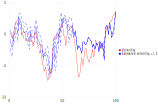

In [222]:
plot(y = X_true[1:100], color = :red, lab = "Volatility")
plot!(y=X_est[1:100], color = :blue, lab = "Estimated volatility")
plot!(y=X_est[1:100] + sqrt(V_est[1:100]), line=:dot, color = :blue, lab = "+/- 1 SD")
plot!(y=X_est[1:100] - sqrt(V_est[1:100]), line=:dot, color = :blue, lab = "")


The quality of the filter is good initially, but it degrades quickly. For $t=50$ onward, the filtered states fail to track the true volatility, and the bands are narrow. Eventually, the filter collapses for larger values of $t$. The reason for the bad performance is the depletion of the particles. The graph below plots the histograms of the particles at $t=1$, $t=5$, $t=20$ and $t=50$. The histograms show that already at $t=20$ only a few particles receive positive weight while at $t=50$ there is only one active particle.

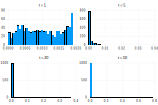

In [224]:
h1 = plot(y=W[:,1];  t = :histogram, title = "t = 1", lab = "");
h2 = plot(y=W[:,5],  t = :histogram, title = "t = 5", lab = "");
h3 = plot(y=W[:,20], t = :histogram, title = "t = 20", lab = "");
h4 = plot(y=W[:,50], t = :histogram, title = "t = 50", lab = "");
subplot(h1, h2, h3, h4)

A way to obviate to the depletion problem is to add a resampling step in the filter. The function `SIR` does just that. `resample!` does the actual resample step.

In [157]:
function resample!(X, w, idx)
    N = size(X, 1)
    sample!(1:N, WeightVec(w), idx)
    for i = eachindex(X)
       @inbounds X[i] = X[idx[i]]
    end
    X
end


function SIR(θ, Y, N=1000)
    T = size(Y,1)
    X = Array(Float64, N, T) ## This will store the particles
    w = Array(Float64, N)
    idx = Array(Int64, N)
    α, σ, β = θ
    ## Initialize -- Draws particles
    rand!(Normal(0, sqrt(σ^2/(1-α^2))), sub(X, :, 1))
    @inbounds for i = 1:N
        w[i] = pdf(Normal(0, β*exp(X[i]/2)), Y[1]) ## W_1 = g(y|X_i)
    end    
    ## Calculate likelihood
    llik = log(mean(w))
    ## Resample step
    resample!(sub(X, :,1), w, idx)    
    @inbounds for j = 2:T
        for i = 1:N            
            X[i,j] = rand(Normal(α*X[i, j-1], σ))
            w[i] = pdf(Normal(0, β*exp(X[i, j]/2)), Y[j])
        end
        llik += log(mean(w))
        resample!(sub(X, :, j), w, idx)
    end
    (X, llik)
end

SIR (generic function with 2 methods)

In [225]:
@time X, llik = SIR(θ,Y, 000);

  0.058860 seconds (4.52 k allocations: 19.326 MB)


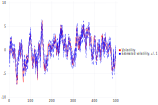

In [19]:
X_est = mean(X, 1)'
V_est = var(X, 1)'
plot(y = X_true[1:500], color = :red, lab = "Volatility")
plot!(y=X_est[1:500], color = :blue, lab = "Estimated volatility")
plot!(y=X_est[1:500] + sqrt(V_est[1:500]), line=:dot, color = :blue, lab = "+/- 1 SD")
plot!(y=X_est[1:500] - sqrt(V_est[1:500]), line=:dot, color = :blue, lab = "")


In [22]:
X, llik = SIR(θ,Y, 1000);
llik

-579.2373705669368

## Particle MCMC

Bluntly put, the pMCMC consist in using the marginal likelihood obtained from the particle filter as the likelihood in a Metropolis-Hastings algorithm to obtain draws from the posterior of $\theta$
$$
p(\theta|y_{1:T}) \propto p_{\theta}(Y_{1:T})p(\theta)
$$
A key result is that the particle filter estimator of the likelihood $\hat{p}_{\theta}(y_{1:T})$ is an unbiased estimator of the actual likelihood, that is, it holds
$$
E[\hat{p}_{\theta}(y_{1:T})] = p_{\theta}(y_{1:T}).
$$

The function `SIR` returns (the second argument) the log-likelihood evaluated at a given value of $\theta$. Since for the pMCMC we only need this, we can  rewrite the code to be a bit more efficient

In [226]:

function llikSIR(θ, Y, N=1000)
      T = size(Y,1)
    X = Array(Float64, N, T) ## This will store the particles
    w = Array(Float64, N)
    idx = Array(Int64, N)
    α, σ, β = θ
    ## Initialize -- Draws particles
    rand!(Normal(0, sqrt(σ^2/(1-α^2))), sub(X, :, 1))
    @inbounds for i = 1:N
        w[i] = pdf(Normal(0, β*exp(X[i]/2)), Y[1]) ## W_1 = g(y|X_i)
    end    
    ## Calculate likelihood
    llik = log(mean(w))
    ## Resample step
    resample!(sub(X, :,1), w, idx)    
    @inbounds for j = 2:T
        for i = 1:N            
            X[i,j] = rand(Normal(α*X[i, j-1], σ))
            w[i] = pdf(Normal(0, β*exp(X[i, j]/2)), Y[j])
        end
        llik += log(mean(w))
        resample!(sub(X, :, j), w, idx)
    end
    llik
end
nothing

Calculate of $\hat{p}_{\theta}(y_{1:T})$ is relatively fast for this model. 

In [228]:
llikSIR([.9, 1., .5], Y, 1000);
@time llikSIR([.9, 1., .5], Y, 1000);

  0.070538 seconds (4.51 k allocations: 19.326 MB, 5.42% gc time)


In [206]:
Γ = Gamma(2,1)
U = Uniform(-1,1)
B = Uniform(0,1)

function lik(parms)
    r = [ logistic(parms[1])*2-1;
              exp(parms[2]);
            logistic(parms[3])]
    llikSIR(r, Y, 1000) + logpdf(Γ, r[2])
end

init = [StatsFuns.logit(.9), 0.0, StatsFuns.logit(0.5)]
lik(init)

n      = 20000
burnin = 20

sim = Chains(n, 3, names = ["α", "σ", "β"]);

theta = RWMVariate(init, [0.2, 0.2, .2], lik, proposal = Normal);

for i in 1:n
    sample!(theta)
    sim[i, :, 1] = [logistic(theta[1]); exp(theta[2]); logistic(theta[3])]
    if mod(i, 1000) == 0
        println("Iteration ", i, ": ", theta.value)
    end
end

LoadError: LoadError: syntax: incomplete: invalid string syntax
while loading In[206], in expression starting on line 22

In [203]:
changerate(sim)

             Change Rate
           α       0.619
           σ       0.619
           β       0.619
Multivariate       0.619



In [ ]:
describe(sim)

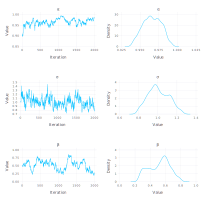

In [205]:
p = Mamba.plot(sim);
draw(p)